# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

# from tensorflow.keras.preprocessing import flow_from_dataframe

In [ ]:
ls /datasets/faces/

final_files/  labels.csv


In [ ]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')

labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
len(labels_df)

7591

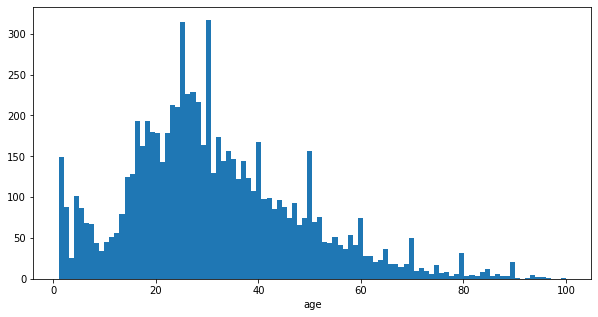

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(labels_df['real_age'], bins=100)
ax.set_xlabel('age')

plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode="raw"
)

Found 7591 validated image filenames.


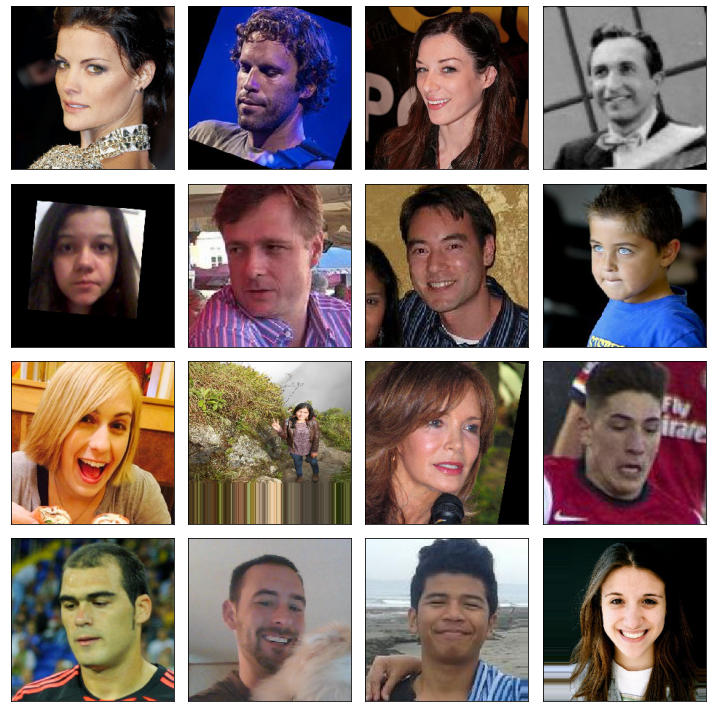

In [ ]:
features, target = next(train_datagen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### EDA

> Проведите исследовательский анализ данных

* Всего в выборке 7591 изображение. Как правило, на фотографиях лица изорбражены крупным планом и в центре, но иногда попадаются фотографии в полный рост

* Пик распределения по возрасту приходится на 30 лет. Второй пик наблюдается ближе к нулевому возрасту. В сторону больших возрастов тянется плавно убывающий хвост


> Сделайте выводы о том, как результаты исследования повлияют на обучение модели

* К исходным данным будет полезно применить аугментацию

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

def load_train(path):

    print('*' * 80)
    print(path)
    print('*' * 80)

    labels_df = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset='training',
        seed=12345
    )

    return train_datagen_flow

def load_test(path):

    labels_df = pd.read_csv(path + 'labels.csv')

    validation_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    val_datagen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    # замораживаем ResNet50 без верхушки
    # backbone.trainable = False

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 238 steps
Epoch 1/15
2022-07-22 07:13:41.985976: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-22 07:13:42.279933: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 74s - loss: 280.5461 - mae: 12.1524 - val_loss: 1083.0161 - val_mae: 28.2445
Epoch 2/15
178/178 - 66s - loss: 100.5610 - mae: 7.5738 - val_loss: 791.1268 - val_mae: 22.9260
Epoch 3/15
178/178 - 66s - loss: 80.5440 - mae: 6.7856 - val_loss: 234.1786 - val_mae: 11.4590
Epoch 4/15
178/178 - 66s - loss: 62.7001 - mae: 6.0179 - val_loss: 165.3824 - val_mae: 9.7786
Epoch 5/15
178/178 - 66s - loss: 54.0444 - mae: 5.5857 - val_loss: 85.1227 - val_mae: 6.9226
Epoch 6/15
178/178 - 66s - loss: 42.0974 - mae: 4.9433 - val_loss: 47.8399 - val_mae: 5.1888
Epoch 7/15
178/178 - 66s - loss: 37.0981 - mae: 4.6369 - val_loss: 70.1562 - val_mae: 6.4318
Epoch 8/15
178/178 - 65s - loss: 32.7492 - mae: 4.3559 - val_loss: 53.4634 - val_mae: 5.6295
Epoch 9/15
178/178 - 65s - loss: 30.4181 - mae: 4.2004 - val_loss: 39.4309 - val_mae: 4.5941
Epoch 10/15
178/178 - 65s - loss: 26.2539 - mae: 3.9298 - val_loss: 49.6669 - val_mae: 5.3770
Epoch 11/15
178/178 - 65s - loss: 22.0327 - mae: 3.6028 - val_loss: 37.6475 - val_mae: 4.4215
Epoch 12/15
178/178 - 65s - loss: 20.9610 - mae: 3.4885 - val_loss: 54.3763 - val_mae: 5.7138
Epoch 13/15
178/178 - 66s - loss: 18.0144 - mae: 3.2365 - val_loss: 35.6480 - val_mae: 4.2890
Epoch 14/15
178/178 - 65s - loss: 16.8667 - mae: 3.1464 - val_loss: 68.9633 - val_mae: 6.6657
Epoch 15/15
178/178 - 65s - loss: 16.2953 - mae: 3.0434 - val_loss: 31.6392 - val_mae: 4.0477
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 37s - loss: 31.6392 - mae: 4.0477
Test MAE: 4.0477

```

## Анализ обученной модели

Напишите выводы здесь

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы